In [1]:
# Original Source: https://www.kaggle.com/teamaker/clustering-teams-based-on-style-of-play
# Dataset https://www.kaggle.com/teamaker/clustering-teams-based-on-style-of-play/data
import pandas as pd
import numpy as np
import sqlite3

In [2]:
con = sqlite3.connect("./database.sqlite")
team=pd.read_sql_query('select * from Team', con)
team_attr=pd.read_sql_query('select * from Team_Attributes', con)
con.close()

df = pd.merge(team, team_attr, how='inner', left_on='team_api_id', right_on='team_api_id')
print (df.shape)

(1458, 29)


In [3]:
df.sample(n=10)

,id_x,team_api_id,team_fifa_api_id_x,team_long_name,team_short_name,id_y,team_fifa_api_id_y,date,buildUpPlaySpeed,buildUpPlaySpeedClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
111,3459,9825,1.0,Arsenal,ARS,73,1,2012-02-22 00:00:00,25,Slow,...,30,Little,Free Form,57,Medium,57,Press,52,Normal,Cover
765,20531,8600,55.0,Udinese,UDI,1302,55,2013-09-20 00:00:00,78,Fast,...,52,Normal,Free Form,40,Medium,63,Press,57,Normal,Cover
571,15630,8226,10029.0,TSG 1899 Hoffenheim,HOF,596,10029,2015-09-10 00:00:00,69,Fast,...,59,Normal,Organised,63,Medium,61,Press,38,Normal,Cover
432,11074,108893,111989.0,AC Arles-Avignon,ARL,62,111989,2012-02-22 00:00:00,23,Slow,...,43,Normal,Organised,44,Medium,32,Contain,36,Normal,Cover
291,8779,8678,1943.0,Bournemouth,BOU,227,1943,2012-02-22 00:00:00,46,Balanced,...,52,Normal,Organised,48,Medium,50,Press,62,Normal,Cover
784,21285,8537,1844.0,Livorno,LIV,753,1844,2014-09-19 00:00:00,58,Balanced,...,77,Lots,Organised,29,Deep,57,Press,32,Narrow,Cover
776,21280,9976,1848.0,Bari,BAR,127,1848,2012-02-22 00:00:00,50,Balanced,...,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover
1247,43041,8388,477.0,CD Numancia,NUM,923,477,2012-02-22 00:00:00,44,Balanced,...,57,Normal,Organised,50,Medium,46,Press,62,Normal,Cover
347,9545,9748,66.0,Olympique Lyonnais,LYO,777,66,2010-02-22 00:00:00,60,Balanced,...,70,Lots,Organised,70,High,60,Press,70,Wide,Offside Trap
1062,35288,10238,665.0,Vitória Setúbal,SET,1357,665,2013-09-20 00:00:00,56,Balanced,...,52,Normal,Organised,37,Medium,37,Press,58,Normal,Cover


In [4]:
cols_to_keep = ['date', 'team_long_name', u'buildUpPlaySpeed', u'buildUpPlayDribbling',
         u'buildUpPlayPassing', u'chanceCreationPassing', u'chanceCreationCrossing',
       u'chanceCreationShooting', u'defencePressure', u'defenceAggression', u'defenceTeamWidth']
df = df[cols_to_keep]

In [5]:
old_df = df.copy(deep=True)

In [6]:
aggs = df.groupby('team_long_name')['date'].max().to_frame()
df.drop('date', axis=1, inplace=True)
df.drop_duplicates(subset='team_long_name', keep='last', inplace=True)
df = df.merge(right=aggs, right_index=True, left_on='team_long_name', how='right')
df = df.dropna()
df.set_index('team_long_name', inplace=True)
df.drop('date', axis=1, inplace=True)
print (df.shape)

(260, 9)


In [37]:
index = old_df.team_long_name[old_df.team_long_name.str.contains(pat = 'ES Troyes AC')].index
for i in index:
    print(old_df.iloc[[i]])


                    date team_long_name  buildUpPlaySpeed  \
469  2011-02-22 00:00:00   ES Troyes AC                35   

     buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
469                   NaN                  50                     50   

     chanceCreationCrossing  chanceCreationShooting  defencePressure  \
469                      50                      35               45   

     defenceAggression  defenceTeamWidth  
469                 45                50  
                    date team_long_name  buildUpPlaySpeed  \
470  2012-02-22 00:00:00   ES Troyes AC                49   

     buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
470                   NaN                  51                     52   

     chanceCreationCrossing  chanceCreationShooting  defencePressure  \
470                      49                      49               43   

     defenceAggression  defenceTeamWidth  
470                 42                52  
  

## KMEANS 

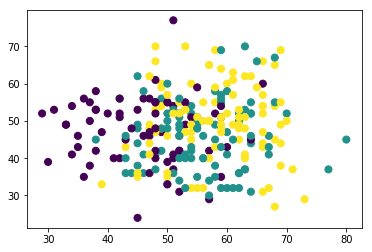

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pylab as pl
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

## KMEANS & PCA

[0.20589458 0.17268013 0.14630594]
0.5248806499908578


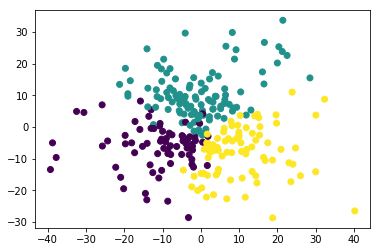

In [20]:
pca = PCA(n_components=3).fit(df)
print(pca.explained_variance_ratio_)
print(np.sum([pca.explained_variance_ratio_]))
pca_2d = pca.transform(df)
kmeans = KMeans(n_clusters = 3, random_state=10)
kmeans.fit(df)
pl.figure('K-means with 3 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.show()

## KMEANS & MDS

In [31]:
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

x = df.copy()
x_normalized = StandardScaler().fit(x).transform(x)  

mds = MDS(n_components = 2, n_init = 10)
mds_2 = MDS(n_components = 3, n_init = 10)
x_mds = mds.fit_transform(x_normalized)
x_mds_2 = mds_2.fit_transform(x_normalized)

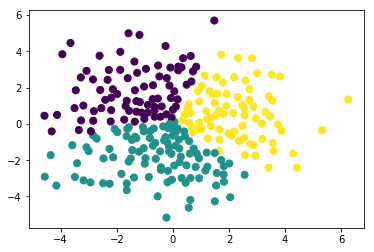

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(x_mds)
y_kmeans = kmeans.predict(x_mds)
plt.scatter(x_mds[:, 0], x_mds[:, 1], c=y_kmeans, s=50, cmap='viridis')

In [39]:
old_df.iloc[[246, 114, 1244, 132, 473]]

,date,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
246,2015-09-10 00:00:00,Swansea City,45,44.0,42,34,36,55,31,47,42
114,2015-09-10 00:00:00,Arsenal,59,51.0,30,28,44,46,51,44,52
1244,2015-09-10 00:00:00,Real Madrid CF,50,57.0,46,61,41,63,52,60,63
132,2015-09-10 00:00:00,Liverpool,66,60.0,45,34,34,46,51,52,61
473,2015-09-10 00:00:00,ES Troyes AC,49,48.0,51,52,49,46,43,42,52


# Spectral Clustering

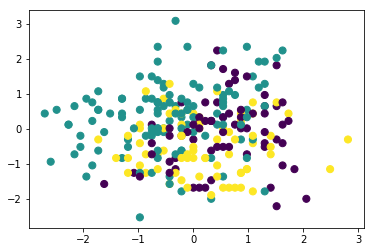

In [77]:
from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=3, affinity='nearest_neighbors', eigen_solver='arpack', n_neighbors=20)
sp_result= spectral.fit_predict(x_normalized)
plt.scatter(x_normalized[:, 0], x_normalized[:, 1], c=sp_result, s=50, cmap='viridis')